In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [12]:
df = pd.read_parquet('df_tratado.parquet')

In [14]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total,DelinquencyLevel
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,3040.0,0.057356,2,1
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,1300.0,0.024375,0,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,3042.0,0.028371,2,3
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,3300.0,0.006008,0,0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1,1750.0,0.093902,0,0


In [13]:
# Criar a variável DelinquencyLevel
df['DelinquencyLevel'] = 0

df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] > 0, 'DelinquencyLevel'] = 1
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] > 0, 'DelinquencyLevel'] = 2
df.loc[df['NumberOfTimes90DaysLate'] > 0, 'DelinquencyLevel'] = 3


In [4]:
df.drop(columns=['NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], inplace=True)

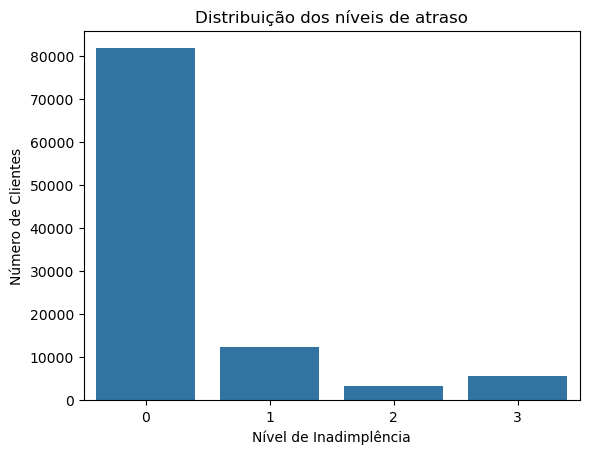

In [5]:
import seaborn as sns
sns.countplot(x='DelinquencyLevel', data=df)
plt.title('Distribuição dos níveis de atraso')
plt.xlabel('Nível de Inadimplência')
plt.ylabel('Número de Clientes')
plt.show()


In [6]:
df_proc = df.copy()

# Tratar MonthlyIncome com logaritmo 
df_proc['MonthlyIncome_log'] = np.log1p(df_proc['MonthlyIncome'].clip(lower=0))

# Limitar DebtRatio e DebtPerLoan para reduzir outliers extremos 
df_proc['DebtRatio_clipped'] = df_proc['DebtRatio'].clip(upper=10) 
df_proc['DebtPerLoan_clipped'] = df_proc['DebtPerLoan'].clip(upper=100)  

# Seleção de colunas para o modelo
cols_to_use = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
 'NumberOfDependents', 'IncomePerDependent',
    'Pagamentos_atrasados_Total', 'MonthlyIncome_log', 'DebtRatio_clipped', 'DebtPerLoan_clipped'
]

X = df_proc[cols_to_use]
y = df_proc['DelinquencyLevel']

X.shape

(103205, 10)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [8]:
# Regressão Logística Multiclasse com SMOTE
pipe_log_multi = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),
    ('model', LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=5000,
        random_state=42))
])

# Naive Bayes
pipe_nb_multi = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),
    ('model', GaussianNB())
])

# Logística Polinomial Multiclasse (opcional)
pipe_poly_multi = ImbPipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),
    ('model', LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=5000,
        random_state=42))
])


Treinando Logística Multiclasse...


c:\Users\renan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logística Multiclasse - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24516
           1       0.78      0.72      0.75      3707
           2       0.26      0.29      0.27      1024
           3       0.58      0.64      0.61      1715

    accuracy                           0.92     30962
   macro avg       0.66      0.66      0.66     30962
weighted avg       0.93      0.92      0.92     30962



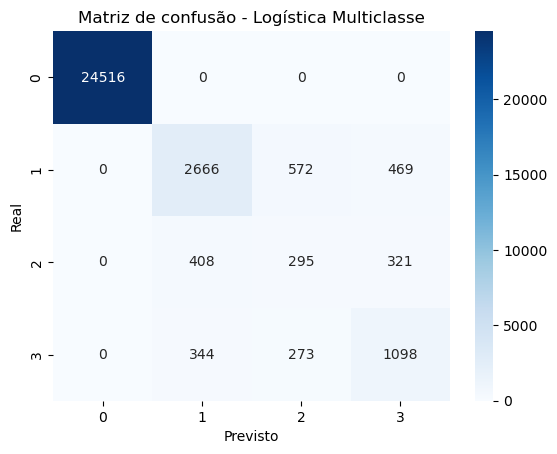

Treinando Naive Bayes Multiclasse...

Naive Bayes Multiclasse - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24516
           1       0.76      0.74      0.75      3707
           2       0.24      0.29      0.26      1024
           3       0.58      0.55      0.56      1715

    accuracy                           0.92     30962
   macro avg       0.65      0.64      0.64     30962
weighted avg       0.92      0.92      0.92     30962



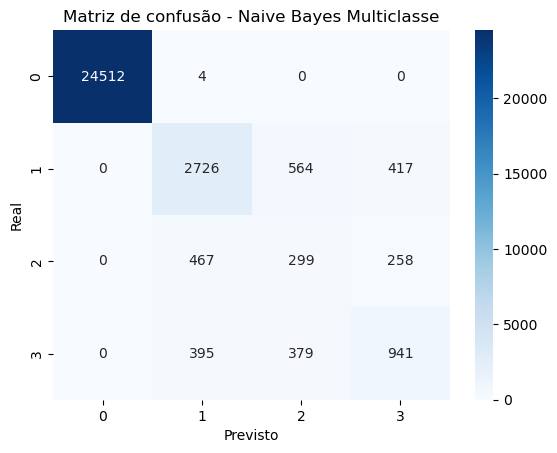

Treinando Polinomial Multiclasse...


c:\Users\renan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\renan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\renan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\renan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\renan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi


Polinomial Multiclasse - Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24516
           1       0.78      0.72      0.75      3707
           2       0.25      0.34      0.29      1024
           3       0.63      0.58      0.60      1715

    accuracy                           0.92     30962
   macro avg       0.66      0.66      0.66     30962
weighted avg       0.93      0.92      0.92     30962



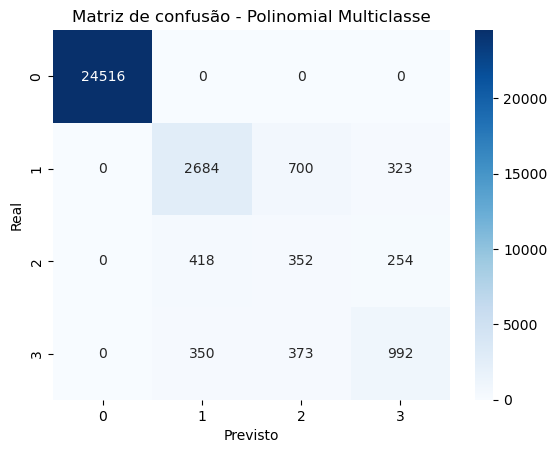

,Modelo,Acurácia,F1-Macro,F1-Weighted
2,Polinomial Multiclasse,0.921904,0.660358,0.924555
0,Logística Multiclasse,0.922905,0.657622,0.924185
1,Naive Bayes Multiclasse,0.919773,0.643942,0.921199


In [9]:
modelos = {
    'Logística Multiclasse': pipe_log_multi,
    'Naive Bayes Multiclasse': pipe_nb_multi,
    'Polinomial Multiclasse': pipe_poly_multi
}

resultados = []

for nome, modelo in modelos.items():
    print(f'Treinando {nome}...')
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    resultados.append({
        'Modelo': nome,
        'Acurácia': acc,
        'F1-Macro': f1_macro,
        'F1-Weighted': f1_weighted
    })
    
    print(f'\n{nome} - Classification Report:\n')
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusão - {nome}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

# Tabela comparativa
pd.DataFrame(resultados).sort_values('F1-Macro', ascending=False)


In [10]:
import joblib

# Caminho do arquivo
model_path = 'modelo_polinomial_multicase.pkl'
best_name = 'Polinomial Multiclasse'
# Salvar o modelo 
joblib.dump(pipe_poly_multi, model_path)

print(f" Modelo '{best_name}' salvo com sucesso em: {model_path}")


 Modelo 'Polinomial Multiclasse' salvo com sucesso em: modelo_polinomial_multicase.pkl


In [11]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total,DelinquencyLevel
1,1,0.766127,45,0.802982,9120.0,13,6,2,3040.0,0.057356,2,1
2,0,0.957151,40,0.121876,2600.0,4,0,1,1300.0,0.024375,0,0
3,0,0.658180,38,0.085113,3042.0,2,0,0,3042.0,0.028371,2,3
4,0,0.233810,30,0.036050,3300.0,5,0,0,3300.0,0.006008,0,0
6,0,0.213179,74,0.375607,3500.0,3,1,1,1750.0,0.093902,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,1.000000,22,0.000000,820.0,1,0,0,820.0,0.000000,0,0
149995,0,0.385742,50,0.404293,3400.0,7,0,0,3400.0,0.050537,0,0
149996,0,0.040674,74,0.225131,2100.0,4,1,0,2100.0,0.045026,0,0
149999,0,0.000000,30,0.000000,5716.0,4,0,0,5716.0,0.000000,0,0
